# 1. PROBLEM STATEMENT



* [Alzheimer's disease (AD)](https://en.wikipedia.org/wiki/Alzheimer%27s_disease) is a neurodegenerative disorder of uncertain cause and pathogenesis that primarily affects older adults and is the most common cause of dementia.
* The earliest clinical manifestation of AD is selective memory impairment and while treatments are available to ameliorate some symptoms, there is no cure currently available.
* Brain Imaging via magnetic resonance imaging (MRI), is used for evaluation of patients with suspected AD.
* MRI findings include both, local and generalized shrinkage of brain tissue. Below is a pictorial representation of tissue shrinkage: ![braintissue](MRI.jpg)
* Some studies have suggested that MRI features may predict rate of decline of AD and may guide therapy in the future.
* However in order to reach that stage clinicians and researchers will have to make use of machine learning techniques that can accurately predict progress of a patient from mild cognitive impairment to dementia.
* We propose to develop a sound model that can help clinicians do that and predict early alzheimer's.

# DETECTING EARLY ALZHEIMER'S USING MRI DATA AND MACHINE LEARNING
----
## TABLE OF CONTENT
1. Problem Statement
2. Data
  1. Dataset Description
  2. Column Descriptors
3. Related Work
4. Exploratory Data Analysis
5. Data Precrocessing
  1. Removing rows with missing values
  2. Imputation
  3. Splitting Train/Validation/Test Sets
  4. Cross-validation
6. Model
  1. Performance Measure
  2. Logistic Regression
  3. Support Vector Machine
  4. Decision Tree
  5. Random Forest Classifier
  6. AdaBoost
7. Conclusion
  1. Results
  2. Unique Approach
  3. Implementation
  4. Limitation
  5. Further Research
8. Acknowledgements

## TEAM MEMBERS
1. Anand Vikram Singh(1706131)
2. Md Meraj Alam (1706134)
3. Ayush Kumar (1706138)


### 2. DATA
---
The team has found MRI related data that was generated by the Open Access Series of Imaging Studies (OASIS) project that is available both, on their [website](www.oasis-brains.org) and [kaggle](www.kaggle.com/jboysen/mri-and-alzheimers) that can be utilized for the purpose of training various machine learning models to identify patients with mild to moderate dementia.

## 2.A DATASET DESCRIPTION
* We will be using the [longitudinal MRI data](http://www.oasis-brains.org/pdf/oasis_longitudinal.csv).
* The dataset consists of a longitudinal MRI data of 150 subjects aged 60 to 96.
* Each subject was scanned at least once.
* Everyone is right-handed.
* 72 of the subjects were grouped as 'Nondemented' throughout the study.
* 64 of the subjects were grouped as 'Demented' at the time of their initial visits and remained so throughout the study.
* 14 subjects were grouped as 'Nondemented' at the time of their initial visit and were subsequently characterized as 'Demented' at a later visit. These fall under the 'Converted' category.

## 2.B COLUMN DESCRIPTORS  

|COL  |FULL-FORMS                          |
|-----|------------------------------------|
|EDUC |Years of education                  |
|SES  |Socioeconomic Status                |
|MMSE |[Mini Mental State Examination](http://www.dementiatoday.com/wp-content/uploads/2012/06/MiniMentalStateExamination.pdf)       |
|CDR  |[Clinical Dementia Rating](http://knightadrc.wustl.edu/cdr/PDFs/CDR_Table.pdf)            |
|eTIV |[Estimated Total Intracranial Volume](https://link.springer.com/article/10.1007/s12021-015-9266-5) |
|nWBV |[Normalize Whole Brain Volume](https://www.ncbi.nlm.nih.gov/pubmed/11547042)        |
|ASF  |[Atlas Scaling Factor](http://www.sciencedirect.com/science/article/pii/S1053811904003271)                |


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

df = pd.read_csv('oasis_longitudinal.csv')
df.head()

Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  NaN  23.0  0.5  1678  0.736  1.046  
3  NaN  28.0  0.5  1738  0.713  1.010  
4  NaN  22.0  0.5  1698  0.701  1.034

In [3]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) #Mark the coverted patient to Demanted
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

In [4]:
df.head()

Subject ID  Group  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0  OAS2_0001      0         0    1   87    14  2.0  27.0  0.0  1987  0.696   
1  OAS2_0002      1         0    1   75    12  NaN  23.0  0.5  1678  0.736   
2  OAS2_0004      0         0    0   88    18  3.0  28.0  0.0  1215  0.710   
3  OAS2_0005      0         0    1   80    12  4.0  28.0  0.0  1689  0.712   
4  OAS2_0007      1         0    1   71    16  NaN  28.0  0.5  1357  0.748   

     ASF  
0  0.883  
1  1.046  
2  1.444  
3  1.039  
4  1.293

In [5]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

Text(0.5, 1.0, 'Gender and Demented rate')

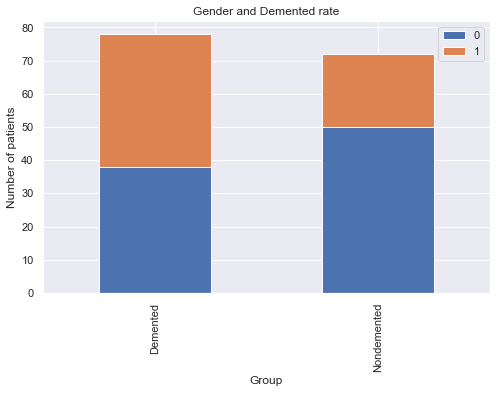

In [6]:
# Gender  and  Group ( Femal=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')

The above graph indicates that men are more likely with dementia than women.

(15.3, 30.0)

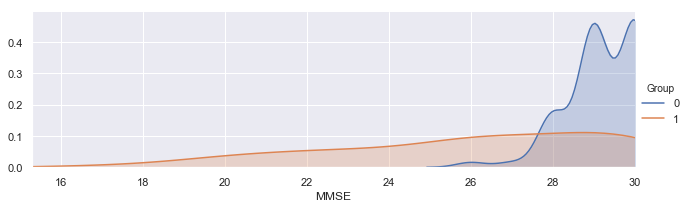

In [7]:
#MMSE : Mini Mental State Examination
# Nondemented = 0, Demented =1
# Nondemented has higher test result ranging from 25 to 30. 
#Min 17 ,MAX 30
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)

The chart shows Nondemented group got much more higher MMSE scores than Demented group.

(0.6, 0.9)

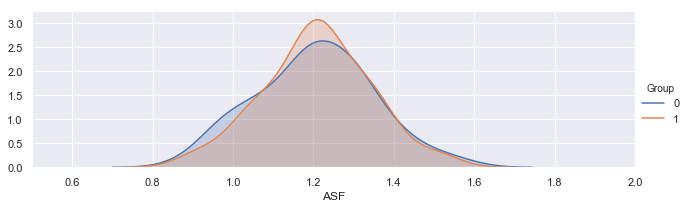

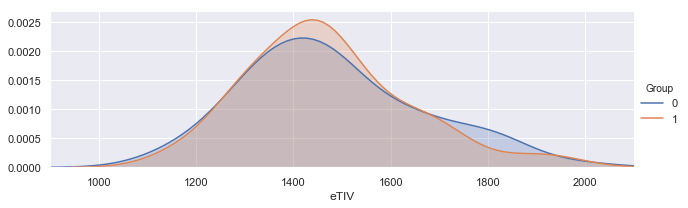

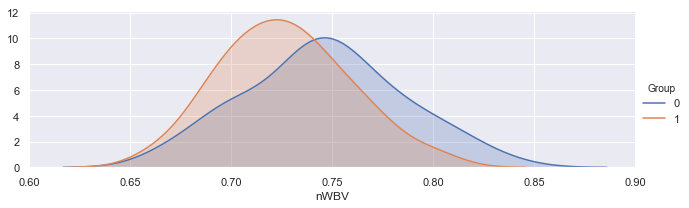

In [8]:
#bar_chart('ASF') = Atlas Scaling Factor
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)

#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

The chart indicates that Nondemented group has higher brain volume ratio than Demented group. This is assumed to be because the diseases affect the brain to be shrinking its tissue. 

(50, 100)

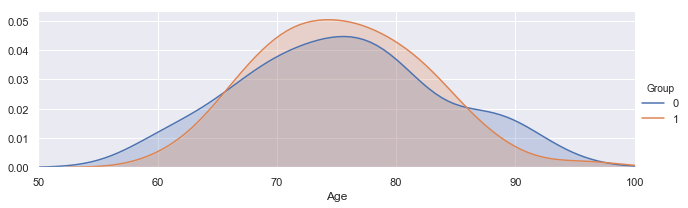

In [9]:
#AGE. Nondemented =0, Demented =0
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

There is a higher concentration of 70-80 years old in the Demented patient group than those in the nondemented patients.
We guess patients who suffered from that kind of disease has lower survival rate so that there are a few of 90 years old.

(0, 0.16)

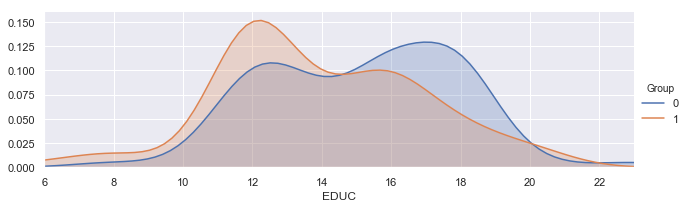

In [10]:
#'EDUC' = Years of Education
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',shade= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

## Intermediate Result Summary
1. Men are more likely with demented, an Alzheimer's Disease, than Women.
2. Demented patients were less educated in terms of years of education.
3. Nondemented group has higher brain volume than Demented group.
4. Higher concentration of 70-80 years old in Demented group than those in the nondemented patients.

# 5. Data Preprocessing
---
We identified 8 rows with missing values in SES column. We deal with this issue with 2 approaches. One is just to drop the rows with missing values. The other is to replace the missing values with the corresponing values, also known as 'Imputation'. Since we have only 150 data, I assume imputation would help the performance of our model.

In [11]:
# Check missing values by each column
pd.isnull(df).sum() 
# The column, SES has 8 missing values

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           8
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

## 5.A Removing rows with missing values

In [12]:
# Dropped the 8 rows with missing values in the column, SES
df_dropna = df.dropna(axis=0, how='any')
pd.isnull(df_dropna).sum()

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [13]:
df_dropna['Group'].value_counts()

0    72
1    70
Name: Group, dtype: int64

## 5.B Imputation

Scikit-learn provides package for imputation [6], but we do it manually. Since the *SES* is a discrete variable, we use median for the imputation.

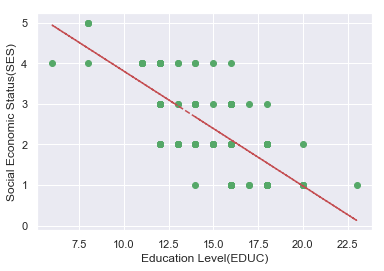

In [14]:
# Draw scatter plot between EDUC and SES
x = df['EDUC']
y = df['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

# Draw trend line in red
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()

In [15]:
df.groupby(['EDUC'])['SES'].median()

EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [16]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)

In [17]:
# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(df['SES']).value_counts()

False    150
Name: SES, dtype: int64

## 5.C Splitting Train/Validation/Test Sets

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

In [19]:
# Dataset with imputation
Y = df['Group'].values # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Dataset after dropping missing value rows
Y = df_dropna['Group'].values # Target for the model
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval_dna)
X_trainval_scaled_dna = scaler.transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)

## 5.D Cross-validation
We conduct 5-fold cross-validation to figure out the best parameters for each model, Logistic Regression, SVM, Decision Tree, Random Forests, and AdaBoost. Since our performance metric is accuracy, we find the best tuning parameters by *accuracy*. In the end, we compare the accuracy, recall and AUC for each model.

# 6. MODEL
---

## 6.A Performance Measures

We use area under the receiver operating characteristic curve (AUC) as our main performance measure. We believe that in case of medical diagnostics for non-life threatening terminal diseases like most neurodegenerative diseases it is important to have a high true positive rate so that all patients with alzheimer's are identified as early as possible. But we also want to make sure that the false positive rate is as low as possible since we do not want to misdiagnose a healthy adult as demented and begin medical therapy. Hence AUC seemed like a ideal choice for a performance measure.

We will also be looking at accuracy and recall for each model.

In the figure below, you can think relevant elements as actually demented subjects.
Precision and Recall [12]
![Precision and Recall](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

## 6.B Logistic Regression
The parameter C, inverse of regularization strength.

Tuning range: [0.001, 0.1, 1, 10, 100]

In [21]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

In [22]:
acc = [] # list to store all performance metric

In [23]:
lm=LogisticRegression

In [24]:
# Dataset with imputation
best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy') # Get recall for each parameter setting
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedLogRegModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)
m = 'Logistic Regression (w/ imputation)'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7541125541125542
Best parameter for regularization (C) is:  10
Test accuracy with best C parameter is 0.7894736842105263
Test recall with the best C parameter is 0.75
Test AUC with the best C parameter is 0.7916666666666667


In [ ]:
# Dataset after dropping missing value rows
best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval_scaled_dna, Y_trainval_dna, cv=kfolds, scoring='accuracy')
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval_scaled_dna, Y_trainval_dna)

test_score = SelectedLogRegModel.score(X_test_scaled_dna, Y_test_dna)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)        
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)

m = 'Logistic Regression (w/ dropna)'
acc.append([m, test_score, test_recall, test_recall, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7009090909090909
Best parameter for regularization (C) is:  10
Test accuracy with best C parameter is 0.75
Test recall with the best C parameter is 0.7
Test AUC with the best C parameter is 0.7944444444444444


In overall, dataset with imputation outperforms the one without imputation. For the later models, we use dataset without imputation.

## 6.C SVM
C: Penalty parameter C of the error term. [0.001, 0.01, 0.1, 1, 10, 100, 1000]

gamma: kernel coefficient. [0.001, 0.01, 0.1, 1, 10, 100, 1000]

kernel: kernel type. ['rbf', 'linear', 'poly', 'sigmoid']

In [ ]:
best_score = 0

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score 
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter
            

# rebuild a model with best parameters to get score 
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test recall with the best parameter is", test_auc)

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on cross validation set is: 0.7715038584603802
Best parameter for c is:  100
Best parameter for gamma is:  0.1
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.8157894736842105
Test recall with the best parameters is 0.7
Test recall with the best parameter is 0.8222222222222222


## 6.D Decision Tree
Maximum depth. [1, 2, ..., 8]

8 is the number of features

In [ ]:
best_score = 0

for md in range(1, 9): # iterate different maximum depth values
    # train the model
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    # perform cross-validation
    scores = cross_val_score(treeModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameter = md

# Rebuild a model on the combined training and validation set        
SelectedDTModel = DecisionTreeClassifier(max_depth=best_parameter).fit(X_trainval_scaled, Y_trainval )

test_score = SelectedDTModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for the maximum depth is: ", best_parameter)
print("Test accuracy with best parameter is ", test_score)
print("Test recall with best parameters is ", test_recall)
print("Test AUC with the best parameter is ", test_auc)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7785431959345004
Best parameter for the maximum depth is:  1
Test accuracy with best parameter is  0.8157894736842105
Test recall with best parameters is  0.65
Test AUC with the best parameter is  0.825


In [ ]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedDTModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.0'],
       ['Age', '0.0'],
       ['EDUC', '0.0'],
       ['SES', '0.0'],
       ['MMSE', '1.0'],
       ['eTIV', '0.0'],
       ['nWBV', '0.0'],
       ['ASF', '0.0']], dtype='<U4')

from sklearn.tree import export_graphviz
import graphviz 
dot_data=export_graphviz(SelectedDTModel, feature_names=X_trainval.columns.values.tolist(),out_file=None)
graph = graphviz.Source(dot_data)  
graph 

## 6.E Random Forest Classifier
n_estimators(M): the number of trees in the forest

max_features(d): the number of features to consider when looking for the best split

max_depth(m): the maximum depth of the tree. 

In [ ]:
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

# Rebuild a model on the combined training and validation set        
SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

In [ ]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedRFModel.feature_importances_)]).T

# 7 RESULTS

In [ ]:
# Performance Metric for each model
result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]